## Imports & Setup
- Loads all required libraries for image handling, model training and analysis
- Uses GPU if available → speeds up training significantly

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import kagglehub
import os
import torch
import torchvision
from PIL import Image
from collections import defaultdict
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torchsummary import summary
import glob
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Dataset Download & Structure Analysis

- Downloads dataset from KaggleHub
- analyze_dataset() walks through dataset folders, counts images per class
- Useful for verifying dataset health and detecting imbalance

In [3]:
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtsrb-german-traffic-sign' dataset.
Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [4]:
def analyze_dataset(root_dir):
    dataset_info = {}
    class_counts = defaultdict(int)  # track image count per class folder

    for root, _, files in os.walk(root_dir):
        rel_dir = os.path.relpath(root, root_dir)

        if rel_dir == ".":  # skip root folder itself
            continue

        file_counts = defaultdict(int)

        for file in files:
            ext = os.path.splitext(file)[1].lower()

            if ext in ['.jpg', '.jpeg', '.png']:  # count only images
                file_counts[ext] += 1
                class_counts[rel_dir] += 1

        if file_counts:
            dataset_info[rel_dir] = dict(file_counts)

    return dataset_info, class_counts


# Run analysis
dataset_structure, class_counts = analyze_dataset(path)

# Print folder → file type count
print("Dataset Structure:")
for folder, types in dataset_structure.items():
    print(f"{folder} → {types}")


Dataset Structure:
Meta → {'.png': 43}
meta → {'.png': 43}
Test → {'.png': 12630}
test → {'.png': 12630}
Train/7 → {'.png': 1440}
Train/17 → {'.png': 1110}
Train/19 → {'.png': 210}
Train/22 → {'.png': 390}
Train/2 → {'.png': 2250}
Train/35 → {'.png': 1200}
Train/23 → {'.png': 510}
Train/10 → {'.png': 2010}
Train/5 → {'.png': 1860}
Train/36 → {'.png': 390}
Train/20 → {'.png': 360}
Train/27 → {'.png': 240}
Train/41 → {'.png': 240}
Train/39 → {'.png': 300}
Train/32 → {'.png': 240}
Train/25 → {'.png': 1500}
Train/42 → {'.png': 240}
Train/8 → {'.png': 1410}
Train/38 → {'.png': 2070}
Train/12 → {'.png': 2100}
Train/0 → {'.png': 210}
Train/31 → {'.png': 780}
Train/34 → {'.png': 420}
Train/18 → {'.png': 1200}
Train/28 → {'.png': 540}
Train/16 → {'.png': 420}
Train/13 → {'.png': 2160}
Train/26 → {'.png': 600}
Train/15 → {'.png': 630}
Train/3 → {'.png': 1410}
Train/1 → {'.png': 2220}
Train/30 → {'.png': 450}
Train/14 → {'.png': 780}
Train/4 → {'.png': 1980}
Train/9 → {'.png': 1470}
Train/21 → {'

In [5]:
TRAIN_DIR = os.path.join(path, "Train")
TEST_DIR = os.path.join(path, "Test")

In [6]:
classes = {
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)',
    2:'Speed limit (50km/h)',
    3:'Speed limit (60km/h)',
    4:'Speed limit (70km/h)',
    5:'Speed limit (80km/h)',
    6:'End of speed limit (80km/h)',
    7:'Speed limit (100km/h)',
    8:'Speed limit (120km/h)',
    9:'No passing',
    10:'No passing veh over 3.5 tons',
    11:'Right-of-way at intersection',
    12:'Priority road',
    13:'Yield',
    14:'Stop',
    15:'No vehicles',
    16:'Veh > 3.5 tons prohibited',
    17:'No entry',
    18:'General caution',
    19:'Dangerous curve left',
    20:'Dangerous curve right',
    21:'Double curve',
    22:'Bumpy road',
    23:'Slippery road',
    24:'Road narrows on the right',
    25:'Road work',
    26:'Traffic signals',
    27:'Pedestrians',
    28:'Children crossing',
    29:'Bicycles crossing',
    30:'Beware of ice/snow',
    31:'Wild animals crossing',
    32:'End speed + passing limits',
    33:'Turn right ahead',
    34:'Turn left ahead',
    35:'Ahead only',
    36:'Go straight or right',
    37:'Go straight or left',
    38:'Keep right',
    39:'Keep left',
    40:'Roundabout mandatory',
    41:'End of no passing',
    42:'End no passing veh > 3.5 tons'
}
num_classes=43

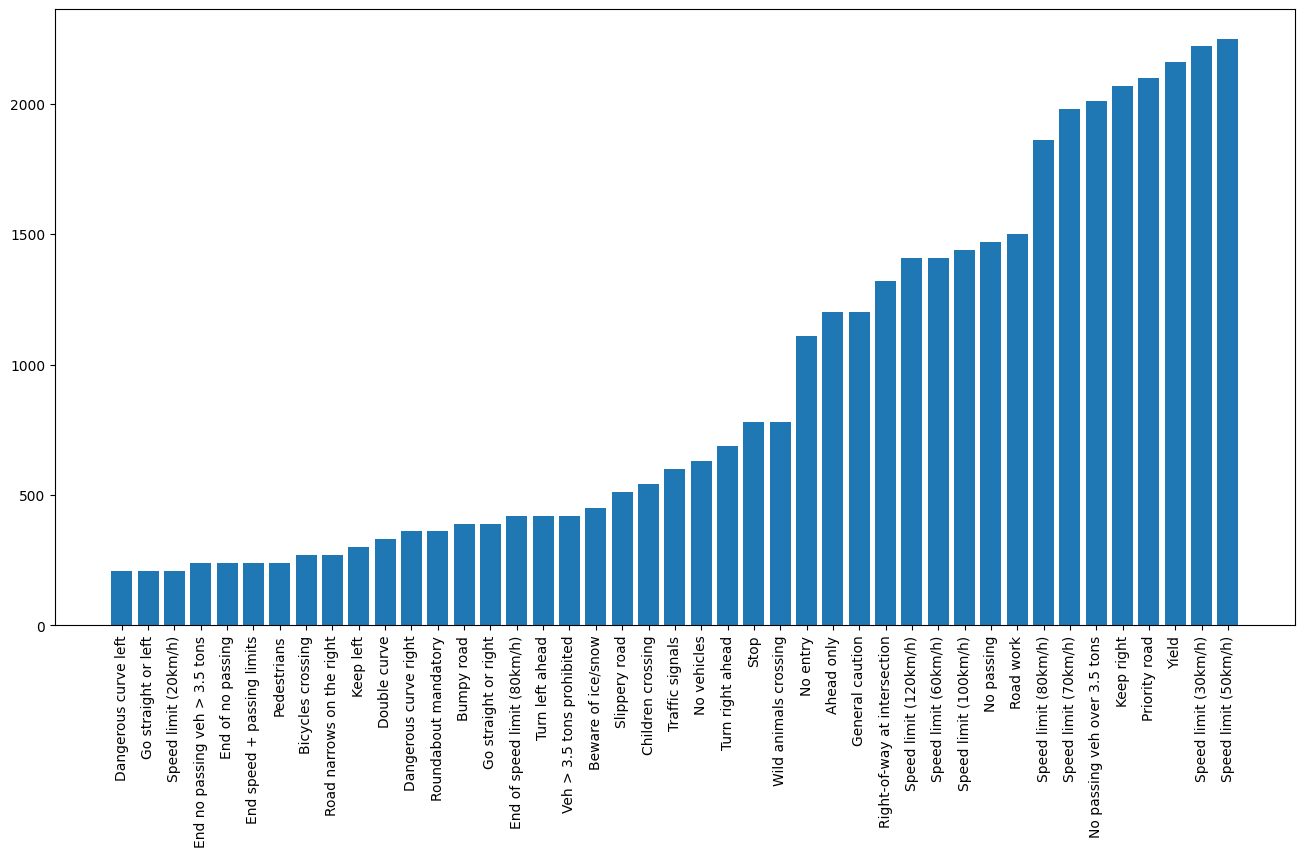

In [7]:
folders = os.listdir(TRAIN_DIR)
train_num = []
class_num = []

for folder in folders:
    train_files = os.listdir(os.path.join(TRAIN_DIR, folder))
    train_num.append(len(train_files))
    class_num.append(classes[int(folder)])

zipped_lists = zip(train_num, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_num, class_num = [ list(tuple) for tuple in  tuples]

# Plotting number of images in each class
plt.figure(figsize=(16, 8))
plt.bar(class_num, train_num)
plt.xticks(class_num, rotation='vertical')
plt.show()

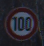

In [8]:
DATA_DIR = os.path.join(path, "Train")
sample_class = os.listdir(DATA_DIR)[0]
sample_img = os.listdir(os.path.join(DATA_DIR, sample_class))[0]
Image.open(os.path.join(DATA_DIR, sample_class, sample_img))

## Custom Dataset Class

- Reads images from folder-based dataset structure
- Each folder name acts as a class label
- __getitem__ returns (image_tensor, label_index)
- transform allows augmentation/normalization during loading


In [9]:
class GTSRBDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        self.image_paths = []
        self.labels = []

        self.classes = sorted(os.listdir(data_dir), key=lambda x: int(x))
        self.class_to_idx = {cls: int(cls) for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(data_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(cls_dir, img_name))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

## Transforms
To mitigate class imbalance and improve generalization for underrepresented traffic sign classes, data augmentation is applied to the training set.

In [11]:
input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

## Data Splitting & DataLoaders

- Split Train Dataset → train 85% + val 15%
- DataLoader batches images → speeds up GPU training
- shuffle=True for training ensures better learning

In [12]:
full_train_dataset = GTSRBDataset(
    TRAIN_DIR,
    transform=train_transform
)
train_size = int(0.85 * len(full_train_dataset))
val_size   = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size]
)

# Override transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform   = test_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
print(len(train_dataset), len(val_dataset))

33327 5882


## EfficientNet CNN model

MODEL: EfficientNet Feature Extractor + Custom Classifier  
Why EfficientNet?
  - Lightweight, high accuracy for vision tasks
  - Good at capturing symbols

Reference:
https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html

### Architecture:
  Pretrained EfficientNet → GlobalAvgPool → Dense layer(s) → Output layer




In [13]:
class GTSRB(nn.Module):
    def __init__(self, num_classes=num_classes):
        super().__init__()

        # Load pre-trained Efficientnet_B0
        self.base_model = models.efficientnet_b0(weights='IMAGENET1K_V1')

        # Freeze base parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output_layer = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        return x

## Training Loop

- Performs forward pass, computes loss & backpropagation
- Tracks accuracy/loss for plotting later
- Validation loop runs without gradient updates

In [14]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model, history

In [15]:
def make_model(learning_rate=0.001):
    model = GTSRB(num_classes=num_classes)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [16]:
lr = 0.001
num_epochs = 5
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
model, optimizer = make_model(learning_rate=lr)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 168MB/s]


In [17]:
model, history = train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Epoch 1/5, Train Loss: 1.7008, Train Acc: 0.7020, Val Loss: 1.2918, Val Acc: 0.8482
Epoch 2/5, Train Loss: 1.2926, Train Acc: 0.8381, Val Loss: 1.2241, Val Acc: 0.8705
Epoch 3/5, Train Loss: 1.2015, Train Acc: 0.8709, Val Loss: 1.2404, Val Acc: 0.8968
Epoch 4/5, Train Loss: 1.1639, Train Acc: 0.8842, Val Loss: 1.1192, Val Acc: 0.9014
Epoch 5/5, Train Loss: 1.1339, Train Acc: 0.8944, Val Loss: 1.1001, Val Acc: 0.9104


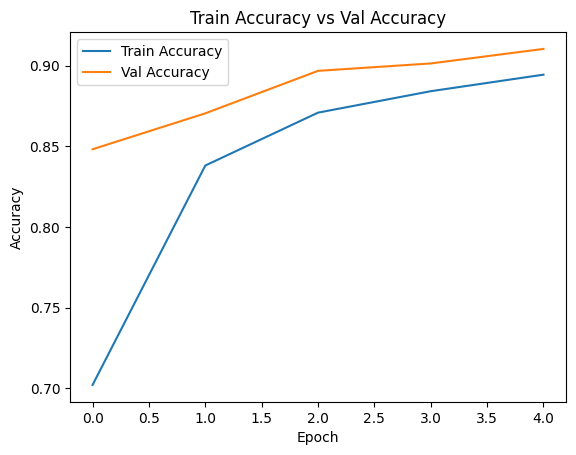

In [18]:
plt.plot(history['train_acc'], label="Train Accuracy")
plt.plot(history['val_acc'], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train Accuracy vs Val Accuracy")
plt.legend()
plt.show()

## HyperParameter Experiments
- Tests performance under different learning rates / layer sizes / dropout
- Helps identify stable model configuration

### Tuning the learning rate
The learning rate controls the step size during gradient updates and has a significant impact on training stability and convergence speed. 

In [19]:
learning_rates = [0.0001, 0.01]
num_epochs = 5
scores = {}
for lr in learning_rates:
    print(f'\n=== Learning Rate: {lr} ===')

    model, optimizer = make_model(learning_rate=lr)
    model, history = train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)
    scores[lr] = history


=== Learning Rate: 0.0001 ===
Epoch 1/5, Train Loss: 2.7166, Train Acc: 0.4336, Val Loss: 2.1758, Val Acc: 0.6100
Epoch 2/5, Train Loss: 1.9831, Train Acc: 0.6362, Val Loss: 1.8790, Val Acc: 0.7032
Epoch 3/5, Train Loss: 1.7328, Train Acc: 0.7021, Val Loss: 1.5888, Val Acc: 0.7596
Epoch 4/5, Train Loss: 1.5987, Train Acc: 0.7442, Val Loss: 1.5001, Val Acc: 0.7832
Epoch 5/5, Train Loss: 1.5131, Train Acc: 0.7755, Val Loss: 1.4406, Val Acc: 0.8065

=== Learning Rate: 0.01 ===
Epoch 1/5, Train Loss: 1.7497, Train Acc: 0.7146, Val Loss: 1.5565, Val Acc: 0.8057
Epoch 2/5, Train Loss: 1.6364, Train Acc: 0.7783, Val Loss: 1.5832, Val Acc: 0.8291
Epoch 3/5, Train Loss: 1.6442, Train Acc: 0.7906, Val Loss: 1.7173, Val Acc: 0.8242
Epoch 4/5, Train Loss: 1.6590, Train Acc: 0.7920, Val Loss: 1.8558, Val Acc: 0.8404
Epoch 5/5, Train Loss: 1.6856, Train Acc: 0.7964, Val Loss: 1.6919, Val Acc: 0.8254


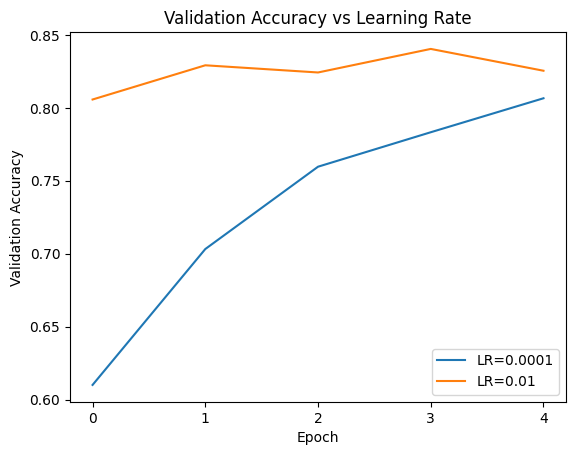

In [20]:
for lr, hist in scores.items():
    plt.plot(hist['val_acc'], label=f"LR={lr}")

plt.xticks(np.arange(5))
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Learning Rate")
plt.legend()
plt.show()

Learning rate of 0.001 achieved higher and more stable validation accuracy.

### Tuning inner layer size
An intermediate fully connected layer is introduced to increase model capacity after the convolutional backbone.

In [21]:
class GTSRB(nn.Module):
    def __init__(self, size_inner=10,num_classes=num_classes):
        super().__init__()

        # Load pre-trained Efficientnet_B0
        self.base_model = models.efficientnet_b0(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)  # New inner layer
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [22]:
def make_model(learning_rate=0.001, size_inner=10):
    model = GTSRB(size_inner=size_inner,num_classes=num_classes)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [23]:
inner_layer_size = [10,20]
num_epochs = 5
lr = 0.001
scores = {}
for size in inner_layer_size:
    print(f'\n=== Inner Layer Size: {size} ===')

    model, optimizer = make_model(learning_rate=lr, size_inner = size)
    model, history = train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)
    scores[size] = history


=== Inner Layer Size: 10 ===
Epoch 1/5, Train Loss: 2.3290, Train Acc: 0.4804, Val Loss: 1.8386, Val Acc: 0.6389
Epoch 2/5, Train Loss: 1.8167, Train Acc: 0.6345, Val Loss: 1.6801, Val Acc: 0.6925
Epoch 3/5, Train Loss: 1.7167, Train Acc: 0.6726, Val Loss: 1.6501, Val Acc: 0.7302
Epoch 4/5, Train Loss: 1.6634, Train Acc: 0.6974, Val Loss: 1.5751, Val Acc: 0.7389
Epoch 5/5, Train Loss: 1.6335, Train Acc: 0.7053, Val Loss: 1.5587, Val Acc: 0.7416

=== Inner Layer Size: 20 ===
Epoch 1/5, Train Loss: 2.0549, Train Acc: 0.5751, Val Loss: 1.5482, Val Acc: 0.7395
Epoch 2/5, Train Loss: 1.5366, Train Acc: 0.7400, Val Loss: 1.4098, Val Acc: 0.7973
Epoch 3/5, Train Loss: 1.4281, Train Acc: 0.7819, Val Loss: 1.3340, Val Acc: 0.8249
Epoch 4/5, Train Loss: 1.3734, Train Acc: 0.8054, Val Loss: 1.2940, Val Acc: 0.8419
Epoch 5/5, Train Loss: 1.3402, Train Acc: 0.8165, Val Loss: 1.5614, Val Acc: 0.8433


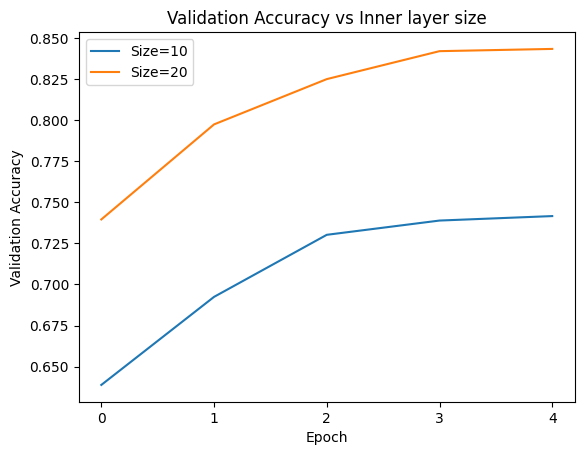

In [24]:
for size, hist in scores.items():
    plt.plot(hist['val_acc'], label=f"Size={size}")

plt.xticks(np.arange(5))
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Inner layer size")
plt.legend()
plt.show()

A size of 20 produced more stable validation performance

### Tuning Dropout rate
Dropout is applied to reduce overfitting in the classifier head.

In [25]:
class GTSRB(nn.Module):
    def __init__(self, size_inner=20, droprate=0.2, num_classes=num_classes):
        super().__init__()

        # Load pre-trained Efficientnet_B0
        self.base_model = models.efficientnet_b0(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)  # Add dropout
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x

In [26]:
def make_model(learning_rate=0.001, size_inner=20,droprate=0.2):
    model = GTSRB(size_inner=size_inner,num_classes=num_classes,droprate=droprate)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [27]:
droprate = [0.2, 0.3]
num_epochs = 5
lr = 0.001
size = 20
scores = {}
for rate in droprate:
    print(f'\n=== Drop rate: {rate} ===')

    model, optimizer = make_model(learning_rate=lr, size_inner = size, droprate = rate)
    model, history = train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)
    scores[rate] = history


=== Drop rate: 0.2 ===
Epoch 1/5, Train Loss: 2.3219, Train Acc: 0.4608, Val Loss: 1.7124, Val Acc: 0.6879
Epoch 2/5, Train Loss: 1.8644, Train Acc: 0.6082, Val Loss: 1.5236, Val Acc: 0.7450
Epoch 3/5, Train Loss: 1.7678, Train Acc: 0.6458, Val Loss: 1.5510, Val Acc: 0.7819
Epoch 4/5, Train Loss: 1.7185, Train Acc: 0.6651, Val Loss: 1.3919, Val Acc: 0.7970
Epoch 5/5, Train Loss: 1.6740, Train Acc: 0.6818, Val Loss: 1.3694, Val Acc: 0.8079

=== Drop rate: 0.3 ===
Epoch 1/5, Train Loss: 2.4298, Train Acc: 0.4193, Val Loss: 1.7609, Val Acc: 0.6680
Epoch 2/5, Train Loss: 2.0098, Train Acc: 0.5498, Val Loss: 1.6275, Val Acc: 0.7271
Epoch 3/5, Train Loss: 1.9214, Train Acc: 0.5832, Val Loss: 1.5149, Val Acc: 0.7557
Epoch 4/5, Train Loss: 1.8723, Train Acc: 0.6010, Val Loss: 1.4609, Val Acc: 0.7734
Epoch 5/5, Train Loss: 1.8433, Train Acc: 0.6148, Val Loss: 1.4781, Val Acc: 0.7926


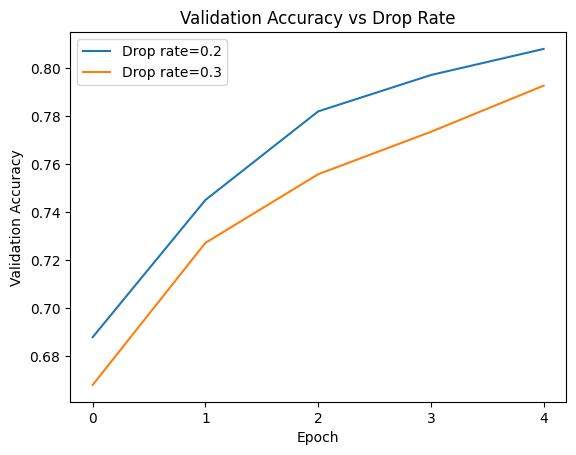

In [28]:
for rate, hist in scores.items():
    plt.plot(hist['val_acc'], label=f"Drop rate={rate}")

plt.xticks(np.arange(5))
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Drop Rate")
plt.legend()
plt.show()

A dropout rate of 0.2 provides an effective trade-off between regularization and information retention.

In [29]:
# Observations:
learning_rate = 0.001
drop_rate = 0.2
inner_layer_size = 20

## Checkpoint Saving

- Saves weights when validation accuracy improves
- Prevents losing best performing model during long training runs

In [30]:
def train_and_evaluate_with_checkpoint(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'efficientnet_b0_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

    return model, history

In [31]:
num_epochs = 20
model, optimizer = make_model(learning_rate=learning_rate, droprate=drop_rate, size_inner=inner_layer_size)
train_and_evaluate_with_checkpoint(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


Epoch 1/20, Train Loss: 2.3310, Train Acc: 0.4563, Val Loss: 1.6972, Val Acc: 0.6831
Checkpoint saved: efficientnet_b0_01_0.683.pth
Epoch 2/20, Train Loss: 1.8760, Train Acc: 0.6066, Val Loss: 1.5197, Val Acc: 0.7450
Checkpoint saved: efficientnet_b0_02_0.745.pth
Epoch 3/20, Train Loss: 1.7677, Train Acc: 0.6479, Val Loss: 1.4533, Val Acc: 0.7776
Checkpoint saved: efficientnet_b0_03_0.778.pth
Epoch 4/20, Train Loss: 1.7111, Train Acc: 0.6686, Val Loss: 1.3791, Val Acc: 0.8053
Checkpoint saved: efficientnet_b0_04_0.805.pth
Epoch 5/20, Train Loss: 1.6801, Train Acc: 0.6788, Val Loss: 1.3548, Val Acc: 0.8055
Checkpoint saved: efficientnet_b0_05_0.806.pth
Epoch 6/20, Train Loss: 1.6611, Train Acc: 0.6852, Val Loss: 1.3611, Val Acc: 0.8172
Checkpoint saved: efficientnet_b0_06_0.817.pth
Epoch 7/20, Train Loss: 1.6443, Train Acc: 0.6938, Val Loss: 1.3092, Val Acc: 0.8268
Checkpoint saved: efficientnet_b0_07_0.827.pth
Epoch 8/20, Train Loss: 1.6308, Train Acc: 0.6986, Val Loss: 1.3087, Val Acc

(GTSRB(
   (base_model): EfficientNet(
     (features): Sequential(
       (0): Conv2dNormActivation(
         (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
         (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): SiLU(inplace=True)
       )
       (1): Sequential(
         (0): MBConv(
           (block): Sequential(
             (0): Conv2dNormActivation(
               (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
               (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
               (2): SiLU(inplace=True)
             )
             (1): SqueezeExcitation(
               (avgpool): AdaptiveAvgPool2d(output_size=1)
               (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
               (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
               (activation): SiLU(inplace=True)
    

In [32]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

## Evaluation on Test Data

Steps:
  1. Model.set eval() → disables dropout & gradients
  2. Predict on test set
  3. Plot confusion matrix → see per-class performance
  4. Generate classification report (precision/recall/F1)

In [33]:
#Find best checkpoint
list_of_files = glob.glob('efficientnet_b0_*.pth')
latest_file = max(list_of_files, key=os.path.getctime)
print(f"Loading model from: {latest_file}")

Loading model from: efficientnet_b0_20_0.849.pth


In [34]:
class GTSRBInferenceDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.transform = transform
        self.images = sorted([
            os.path.join(data_dir, f)
            for f in os.listdir(data_dir)
            if f.endswith(".png")
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(self.images[idx])


In [35]:
# Load model
model = GTSRB(size_inner=inner_layer_size, droprate=drop_rate, num_classes=num_classes)
model.load_state_dict(torch.load(latest_file))
model.to(device)
model.eval()

GTSRB(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_acti

In [ ]:
test_dataset = GTSRBInferenceDataset(TEST_DIR, test_transform)
test_loader = DataLoader(test_dataset, batch_size=32)

predictions = {}

with torch.no_grad():
    for images, names in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        for name, pred in zip(names, preds):
            predictions[name] = pred


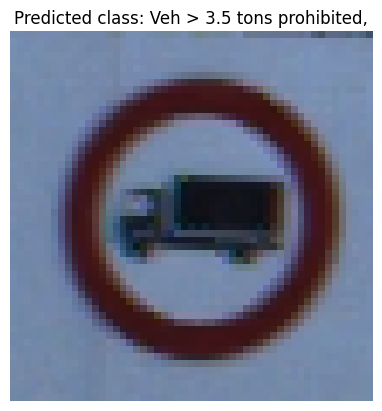

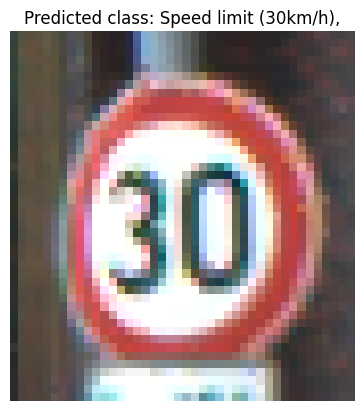

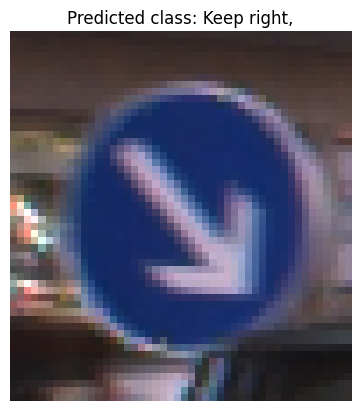

In [38]:
def show_prediction(img_name, pred_class):
    img_path = os.path.join(TEST_DIR, img_name)
    img = Image.open(img_path)

    plt.imshow(img)
    plt.title(f"Predicted class: {classes[pred_class]},")
    plt.axis("off")
    plt.show()

# Show 5 predictions
for i, (name, pred) in enumerate(predictions.items()):
    show_prediction(name, pred)
    if i == 2:
        break

## ONNX Export
- Converts PyTorch model → ONNX (Deployment Ready Format)
- Useful for real-time emotion detection apps.


In [39]:
!pip install onnx
!pip install onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 14.3 MB/s eta 0:00:00


In [40]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
onnx_path = "traffic_sign_efficientnet_b0.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

/tmp/ipython-input-1475336786.py:6: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `GTSRB([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `GTSRB([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 99 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 20},
            producer_name='pytorch',
            producer_version='2.9.0+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[s77,3,224,224]>
            ),
            outputs=(
                %"output"<FLOAT,[s77,43]>
            ),
            initializers=(
                %"base_model.features.0.0.weight"<FLOAT,[32,3,3,3]>{Tensor(...)},
                %"base_model.features.1.0.block.0.0.weight"<FLOAT,[32,1,3,3]>{Tensor(...)},
                %"base_model.features.1.0.block.1.fc1.weight"<FLOAT,[8,32,1,1]>{TorchTensor(...)},
                %"base_model.features.1.0.block.1.fc1.bias"<FLOAT,[8]>{TorchTensor<FLOAT,[8]>(Parameter containing: tensor([-1.2193, -0.1298, -1.2465, -1.0992, -1.7503, -1.8147, -1.5511, -0.7177], device='cuda:0'), name='base_model.features.1.0.blo